In [1]:
import os
import sys
print(os.path.abspath(''))

pkg_path = os.path.abspath('..')
print(pkg_path)
sys.path.insert(0, pkg_path)

import csv
import numpy as np

from pyolin.gate import Gate

/home/campus.ncl.ac.uk/b8051106/my/src/python/pyolin/notebooks
/home/campus.ncl.ac.uk/b8051106/my/src/python/pyolin


In [2]:
class ExperimentGate(Gate):
    
    def __init__(self, host, backbone, rbs, repressor, xs, ys):
        super().__init__(f"{rbs}_{repressor}", xs, ys)
        
        self.host = host
        self.backbone = backbone
        self.rbs = rbs
        self.repressor = repressor
        
    def __eq__(self, other):
        return (isinstance(other, ExperimentGate)
                and self.host == other.host
                and self.backbone == other.backbone
                and self.rbs == other.rbs
                and self.repressor == other.repressor)
    
    def __str__(self):
        return f"{self.name} in {self.host} with {self.backbone}"
    
    def __repr__(self):
        return self.__str__()
    
    
    @property
    def quickplot(self):
        try:
            figure = super().quickplot
            figure.axes[0].set_title(f"{self.name} with {self.backbone} in {self.host}")
            return figure
        except ValueError as e:
            print(f"{self.name} with {self.backbone} in {self.host} didn't work")
            print(e)
        

In [3]:
def parse_gate(filename):
    with open(filename) as file:
        xs = []
        ys = []
        for row in csv.reader(file):
            x = float(row[0])
            y = float(row[1])
            if x > 0.0 and y > 0.0:
                xs.append(x)
                ys.append(y)
            
        pieces = filename.split('_')
        
        return ExperimentGate(pieces[1], 
                              pieces[2], 
                              pieces[4].split('.')[0],
                              pieces[3],
                              xs,
                              ys)

In [4]:
gates = [parse_gate('../data/experiment7/' + filename) for filename in os.listdir('../data/experiment7')]

In [5]:
#for gate in gates:
#    gate.quickplot.savefig(f"{gate.name}_{gate.host}_{gate.backbone}_logfit.png")

/home/campus.ncl.ac.uk/b8051106/my/src/python/pyolin/pyolin/gate.py:66: RuntimeWarning: invalid value encountered in double_scalars
  return (k**n * (ymax - t * ymin) / (t * ymin - ymin))**(1 / n)
/home/campus.ncl.ac.uk/b8051106/my/src/python/pyolin/pyolin/gate.py:53: RuntimeWarning: invalid value encountered in double_scalars
  return ((k**n * ymax * (t - 1)) / (ymax - t * ymin))**(1 / n)
/home/campus.ncl.ac.uk/b8051106/my/src/python/pyolin/pyolin/gate.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  return ((k**n * ymax * (t - 1)) / (ymax - t * ymin))**(1 / n)


There are 89 valid gates
There are 83 compatible combinations


/home/campus.ncl.ac.uk/b8051106/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


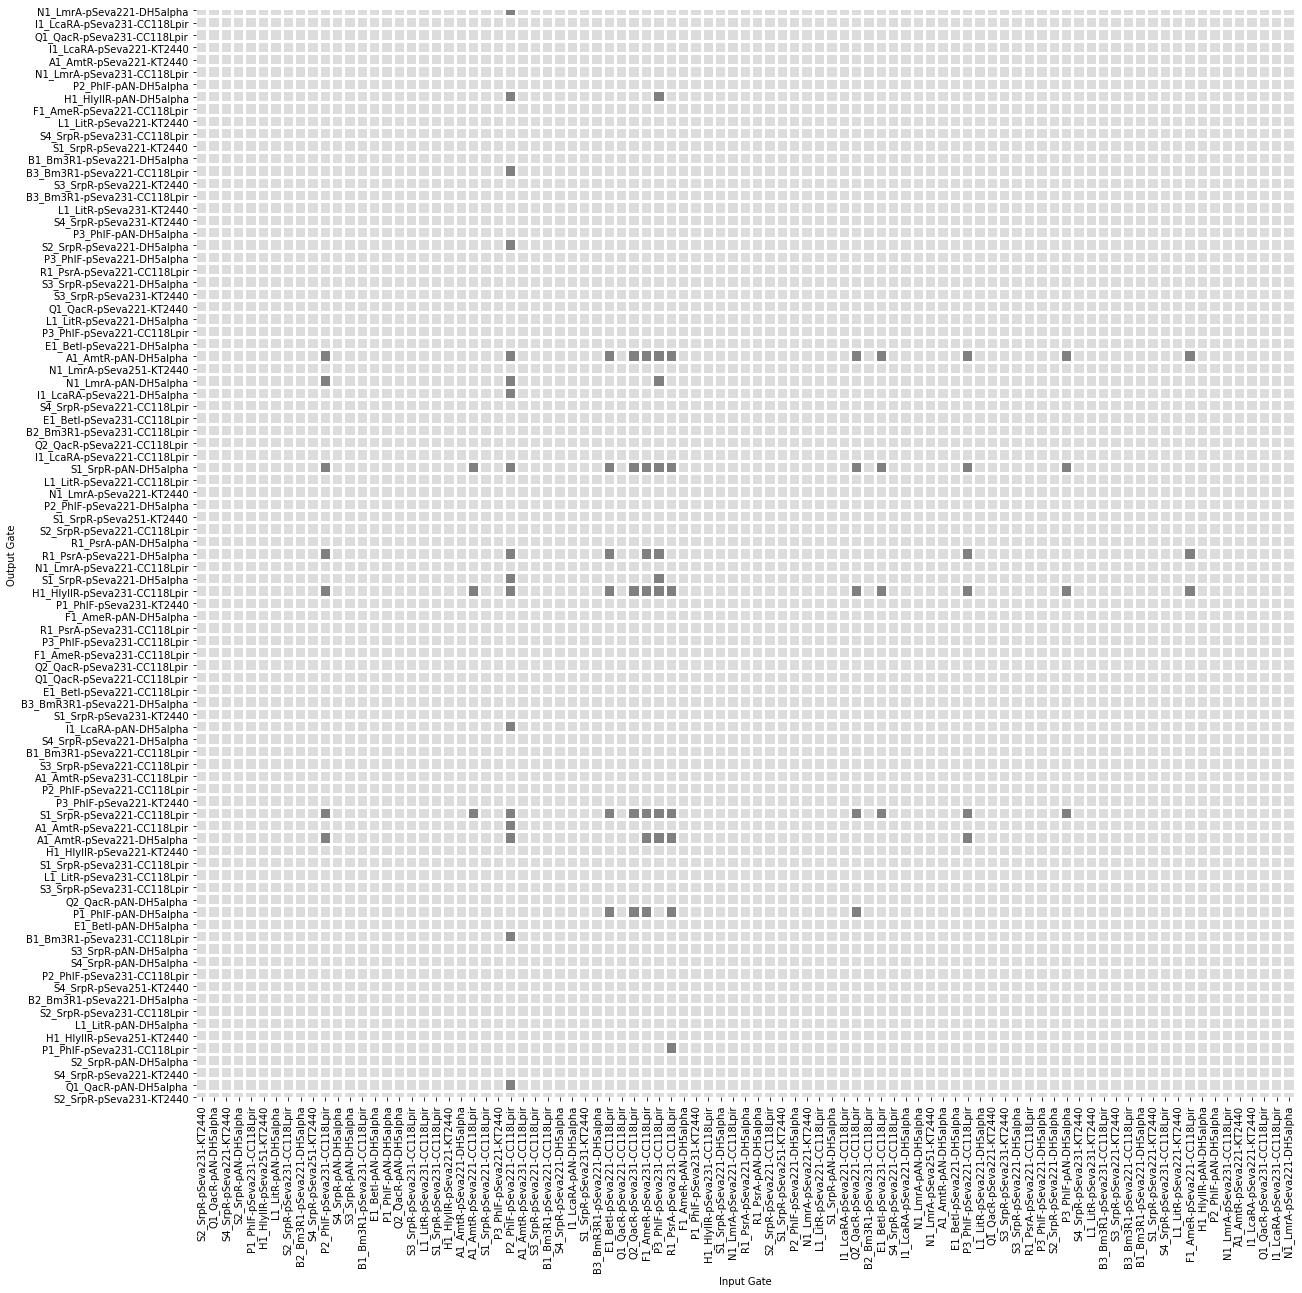

In [6]:
valid_gates = [g for g in filter(lambda x: x.has_valid_thresholds, gates)]
print(f"There are {len(valid_gates)} valid gates")

import matplotlib.pyplot as plot
import seaborn as sns


def compat_map(gates):
    num_gates = len(gates)
    compatibility = np.zeros((num_gates, num_gates), dtype=bool)
    for j in range(num_gates):
        a = gates[j]
        for i in range(num_gates):
            b = gates[i]
            compatibility[i,j] = a.is_compatible_with(b, offset=0.0)

    print(f"There are {np.count_nonzero(compatibility)} compatible combinations")

    figure, axes = plot.subplots(figsize=(20, 20))
    gate_names = [f"{g.name}-{g.backbone}-{g.host}" for g in gates]

    sns.heatmap(compatibility,
                cmap=["gainsboro", "grey"],
                linecolor="white",
                linewidth=2,
                xticklabels=gate_names,
                yticklabels=gate_names,
                cbar=False,
                square=True,
                ax=axes)
    axes.invert_yaxis()
    axes.set_xlabel("Input Gate")
    axes.set_ylabel("Output Gate")

    figure.show()
    
    return compatibility
    
compat_all_matrix = compat_map(valid_gates)

In [7]:
all_paths = []

def dfs_path_collect(adj_matrix, i, visited, paths, gates):
    if not i in visited:
        outgoings = [j for (j, t) in enumerate(adj_matrix[:, i]) if t]
        if not outgoings:
            paths.append([gates[g] for g in visited + [i]])
        else:
            for j in outgoings:
                dfs_path_collect(adj_matrix, j, visited + [i], paths, gates)


for i in range(len(valid_gates)):
    dfs_path_collect(compat_all_matrix, i, [], all_paths, valid_gates)
    
# the longest paths
length_longest = max(map(len, all_paths))
if length_longest > 1:
    print(f"The length of the longest path in all contexts is: {length_longest}")
    longest_paths = [path for path in all_paths if len(path) == length_longest]
    print(f"The longest path/s for all contexts is/are:")
    for path in longest_paths:
        print(f"{','.join(map(str, path))}")
else:
    print("There are no paths in this context")
                      
print("==================================\n\n\n")

The length of the longest path in all contexts is: 3
The longest path/s for all contexts is/are:
P2_PhIF in CC118Lpir with pSeva221,A1_AmtR in CC118Lpir with pSeva221,S1_SrpR in CC118Lpir with pSeva221
P2_PhIF in CC118Lpir with pSeva221,A1_AmtR in CC118Lpir with pSeva221,H1_HIyIIR in CC118Lpir with pSeva231
P2_PhIF in CC118Lpir with pSeva221,A1_AmtR in CC118Lpir with pSeva221,S1_SrpR in DH5alpha with pAN





In [8]:
max(map(len, all_paths))

3

Using gates in KT2440 with pSeva221
There are 10 valid gates
There are 0 compatible combinations
There are no paths in this context



Using gates in KT2440 with pSeva231
There are 6 valid gates
There are 0 compatible combinations
There are no paths in this context



Using gates in KT2440 with pAN
There are 0 valid gates



Using gates in KT2440 with pSeva251
There are 4 valid gates
There are 0 compatible combinations
There are no paths in this context



Using gates in DH5alpha with pSeva221
There are 15 valid gates
There are 0 compatible combinations


/home/campus.ncl.ac.uk/b8051106/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


There are no paths in this context



Using gates in DH5alpha with pSeva231
There are 0 valid gates



Using gates in DH5alpha with pAN
There are 17 valid gates
There are 2 compatible combinations
The length of the longest path in this context is: 2
The longest path/s for this context is/are:
P3_PhIF in DH5alpha with pAN,S1_SrpR in DH5alpha with pAN
P3_PhIF in DH5alpha with pAN,A1_AmtR in DH5alpha with pAN



Using gates in DH5alpha with pSeva251
There are 0 valid gates



Using gates in CC118Lpir with pSeva221
There are 17 valid gates
There are 7 compatible combinations
The length of the longest path in this context is: 3
The longest path/s for this context is/are:
P2_PhIF in CC118Lpir with pSeva221,A1_AmtR in CC118Lpir with pSeva221,S1_SrpR in CC118Lpir with pSeva221



Using gates in CC118Lpir with pSeva231
There are 20 valid gates
There are 7 compatible combinations
The length of the longest path in this context is: 2
The longest path/s for this context is/are:
P2_PhIF in CC118Lpir

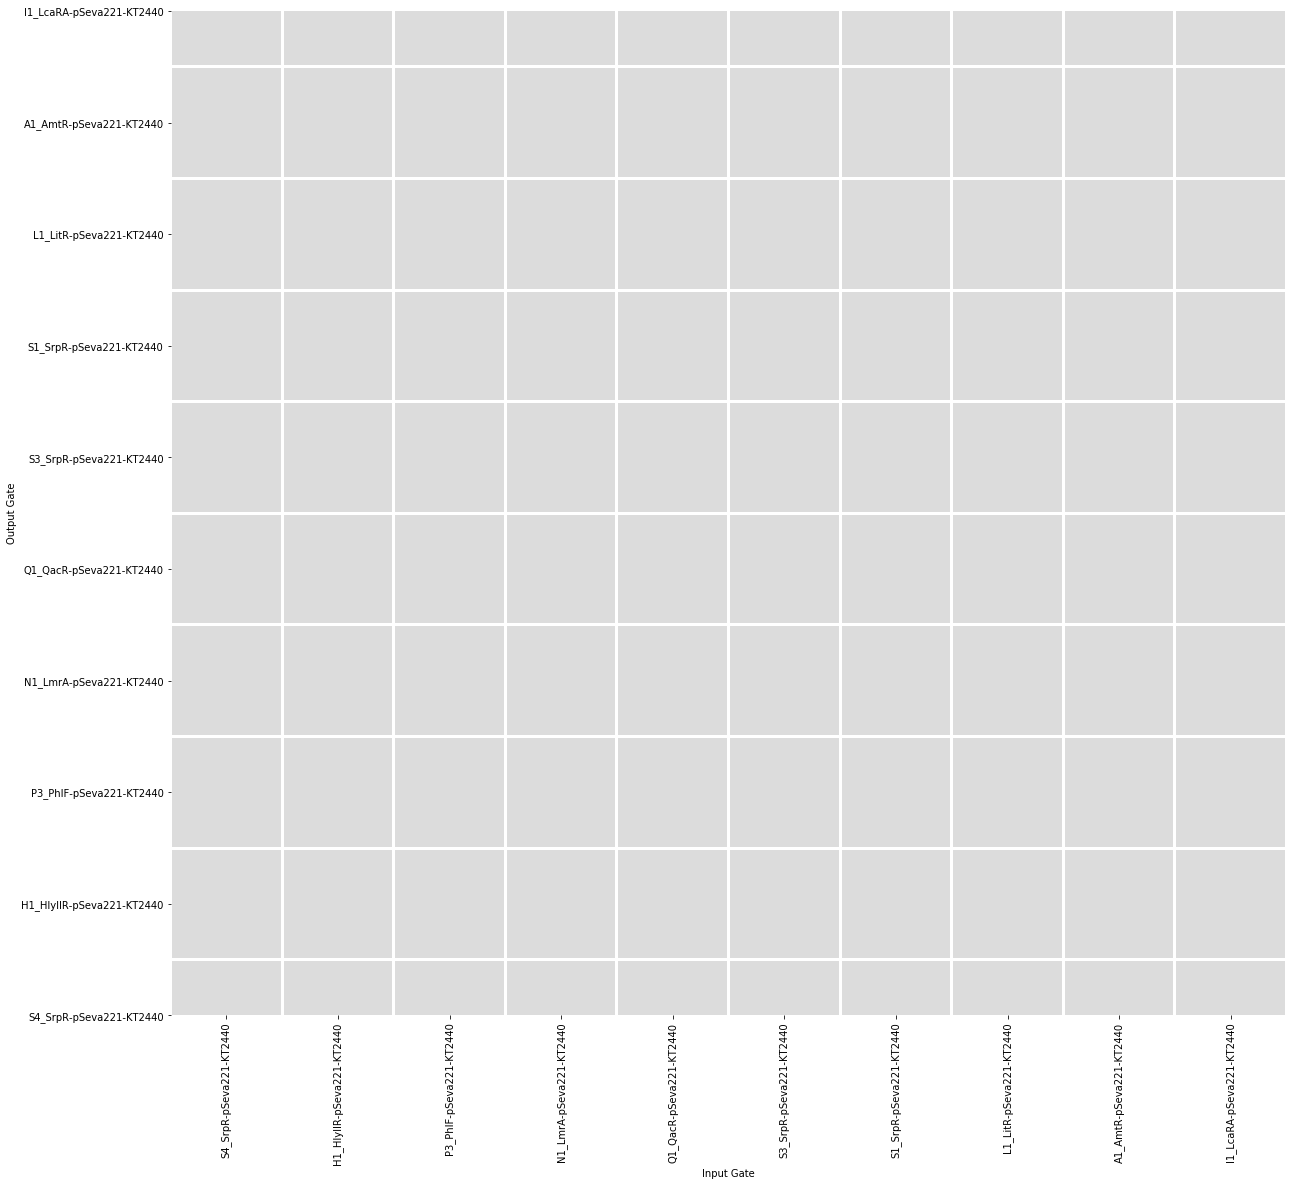

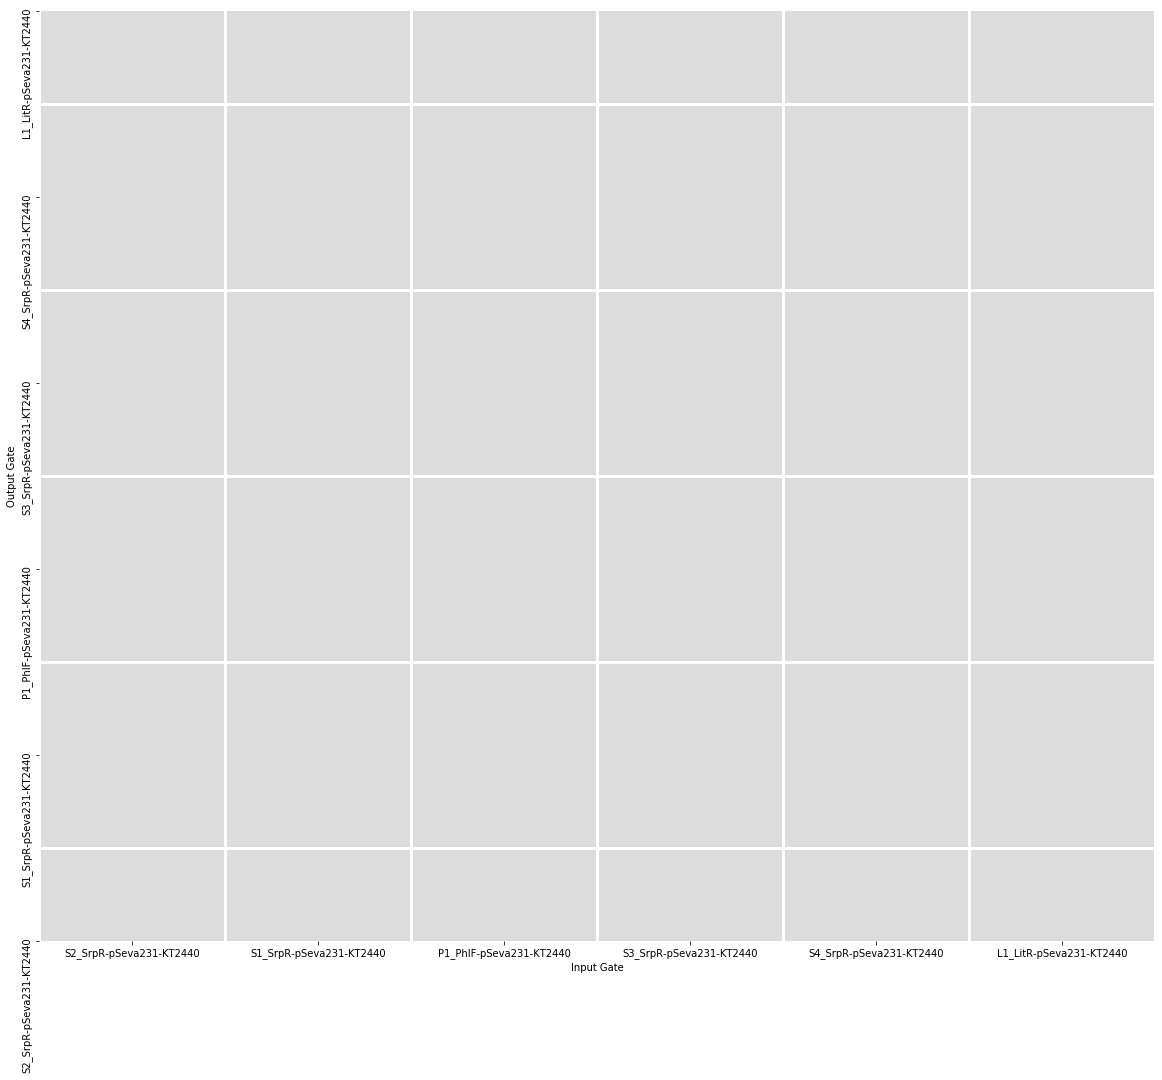

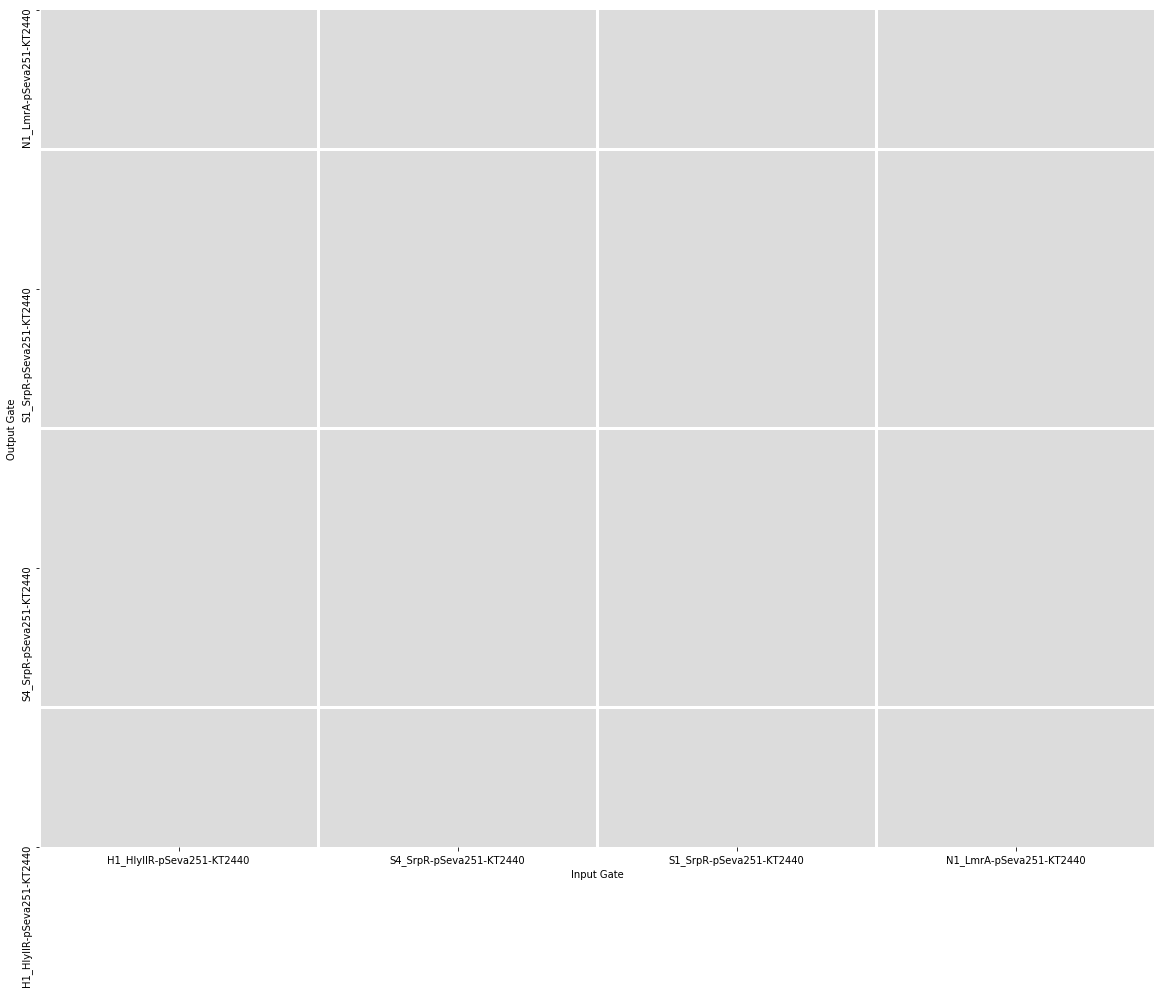

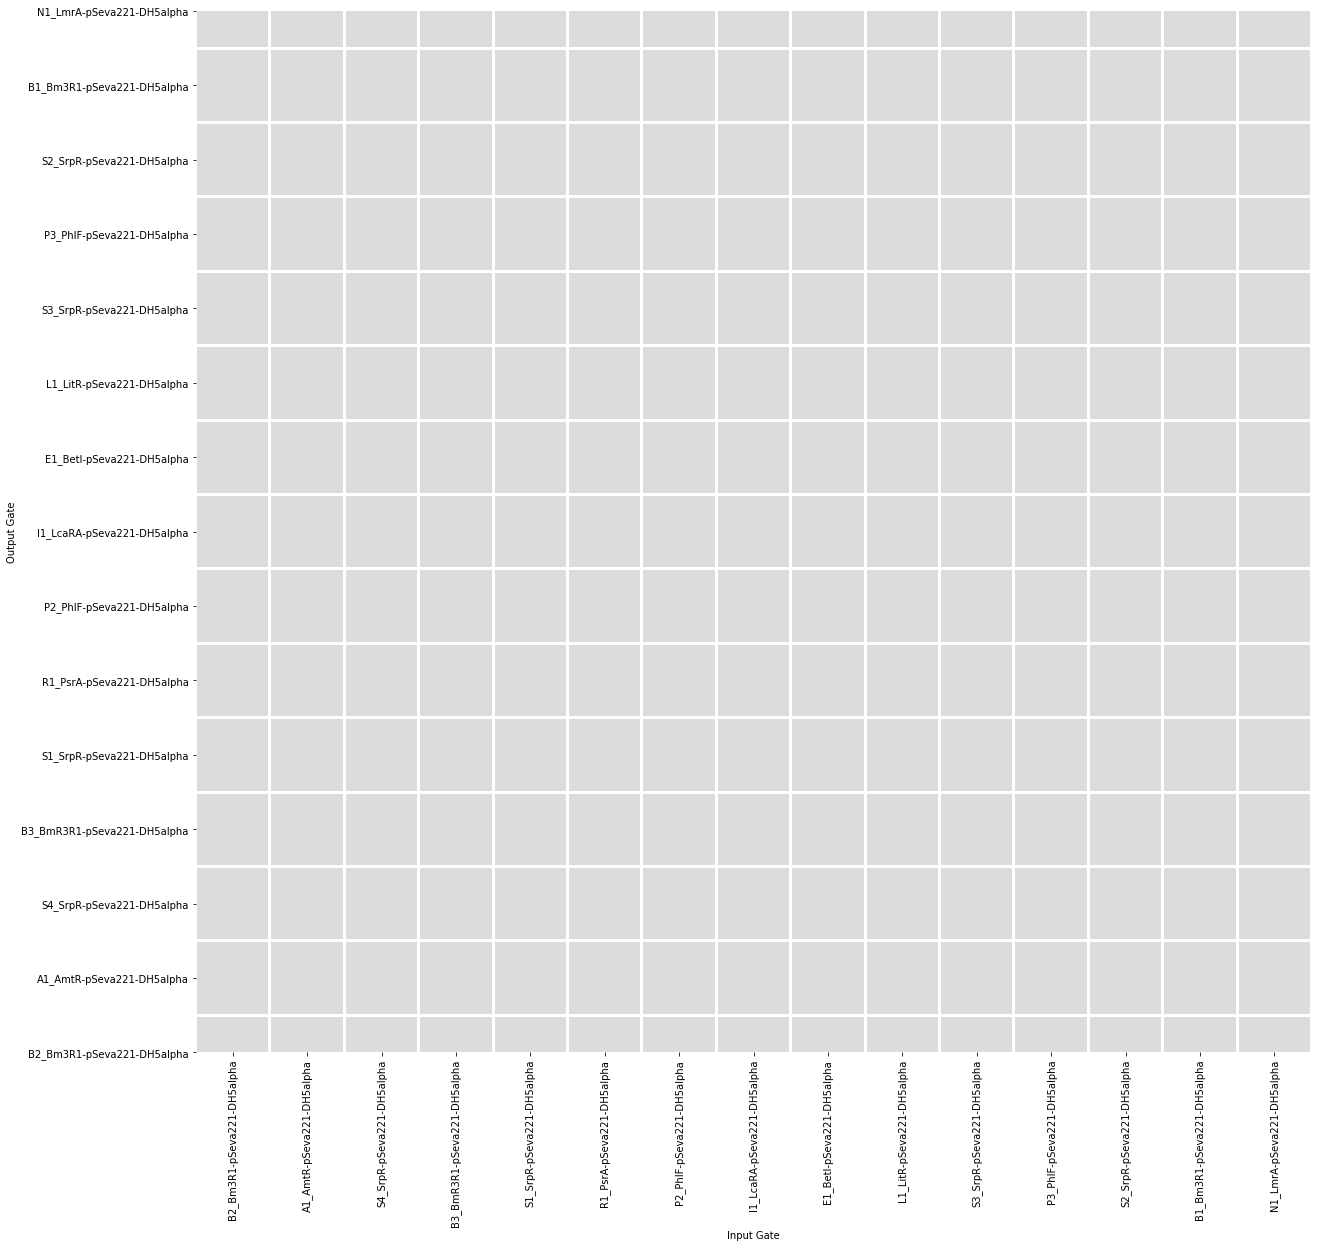

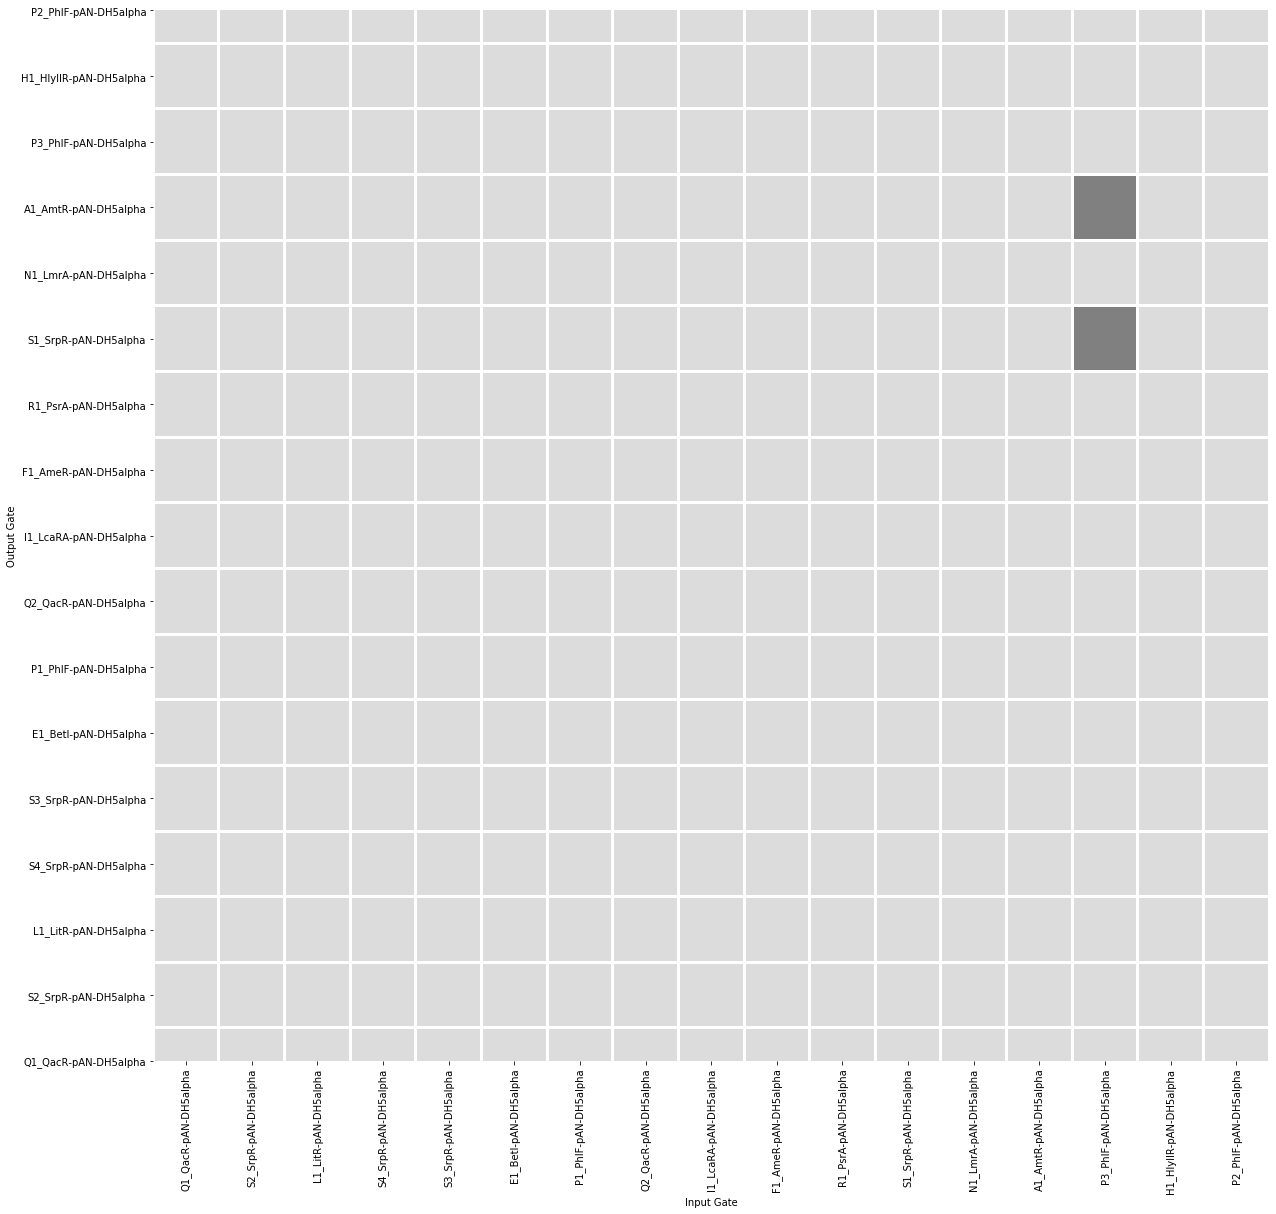

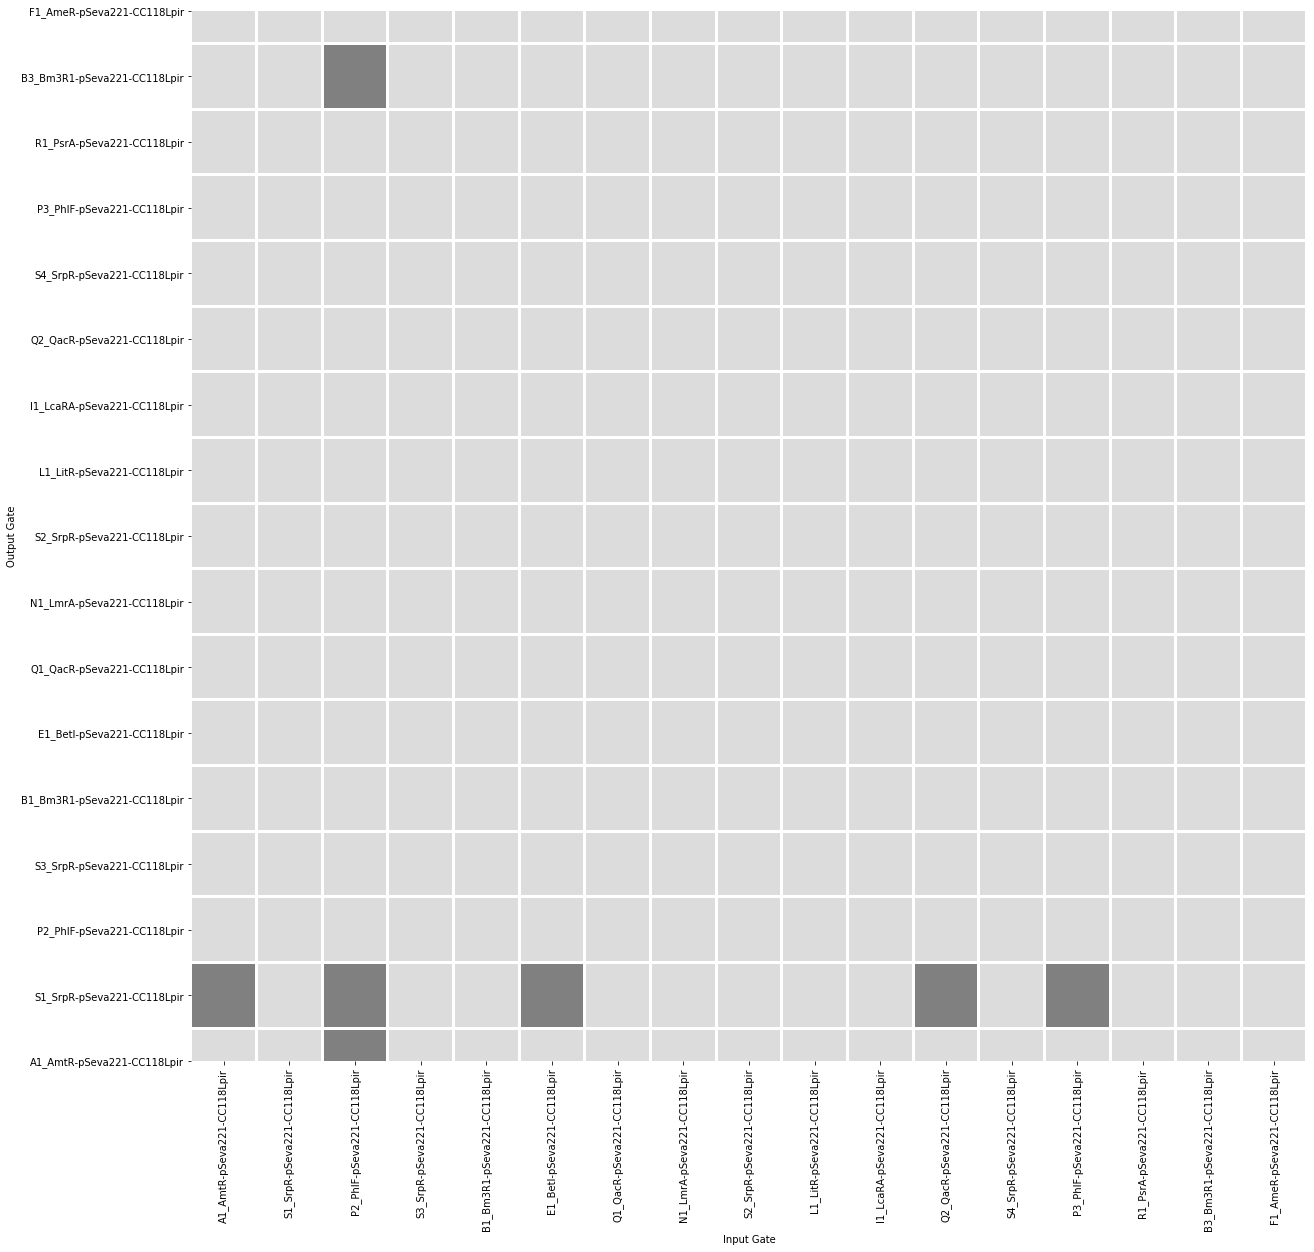

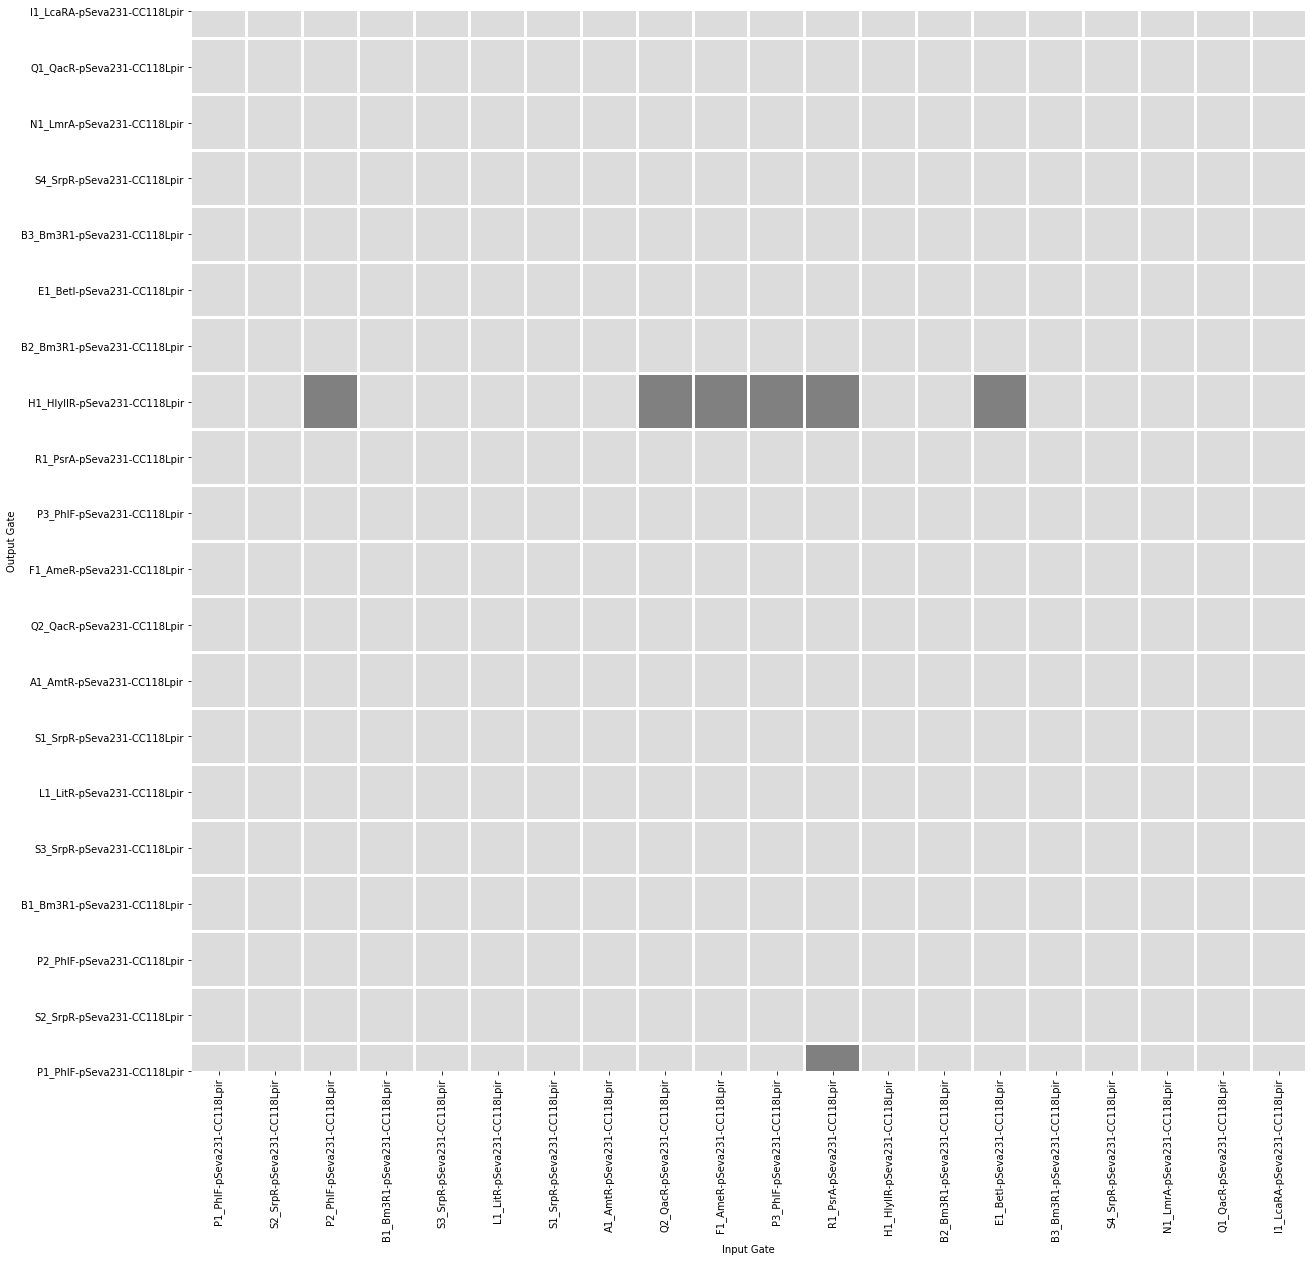

In [9]:
# lets loop over all contexts
hosts = ['KT2440', 'DH5alpha', 'CC118Lpir']
backbones = ['pSeva221', 'pSeva231', 'pAN', 'pSeva251']

for host in hosts:
    for backbone in backbones:
        print(f"Using gates in {host} with {backbone}")
        
        gates = list(filter(lambda g: g.host == host and g.backbone == backbone, valid_gates))
        print(f"There are {len(gates)} valid gates")
        if len(gates) == 0:
            print("==================================\n\n\n")
            continue

        compat_matrix = compat_map(gates)

        paths = []

        for i in range(len(gates)):
            dfs_path_collect(compat_matrix, i, [], paths, gates)
            
        # the longest paths
        length_longest = max(map(len, paths))
        if length_longest > 1:
            print(f"The length of the longest path in this context is: {length_longest}")
            longest_paths = [path for path in paths if len(path) == length_longest]
            print(f"The longest path/s for this context is/are:")
            for path in longest_paths:
                print(f"{','.join(map(str, path))}")
        else:
            print("There are no paths in this context")
                      
        print("==================================\n\n\n")

/home/campus.ncl.ac.uk/b8051106/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


There are 17 valid gates.
There are 2 compatible combinations


/home/campus.ncl.ac.uk/b8051106/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False

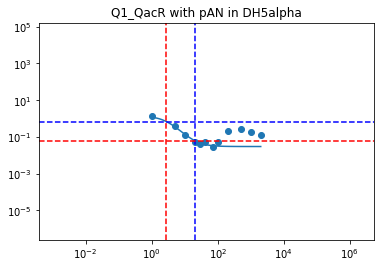

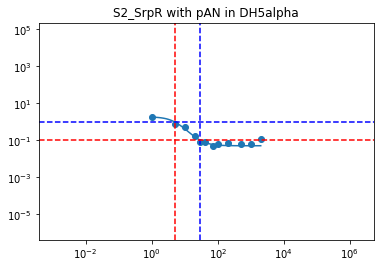

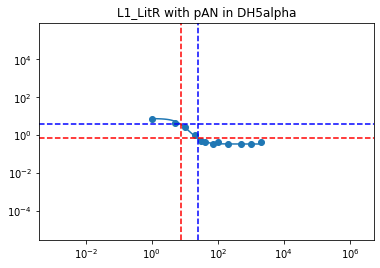

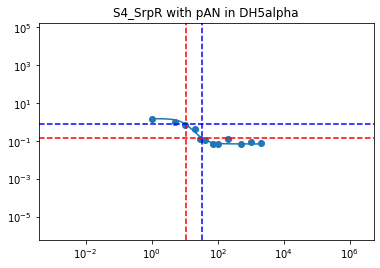

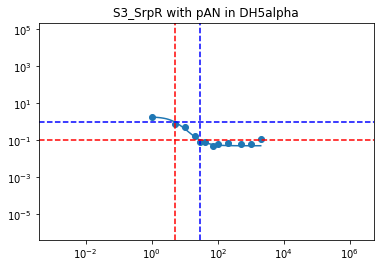

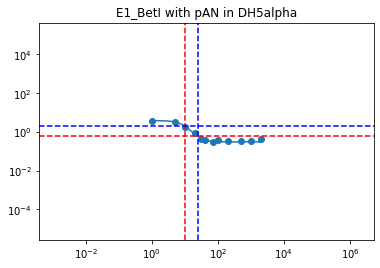

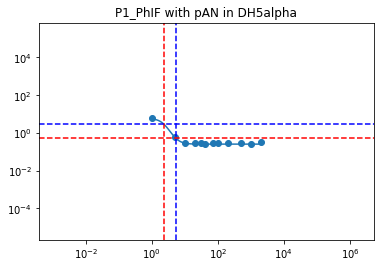

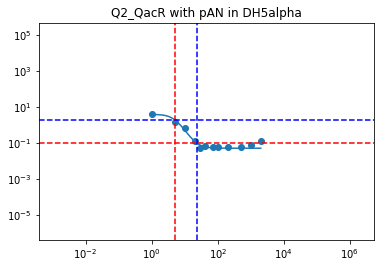

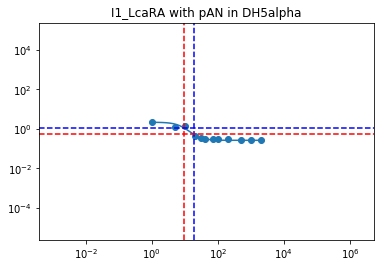

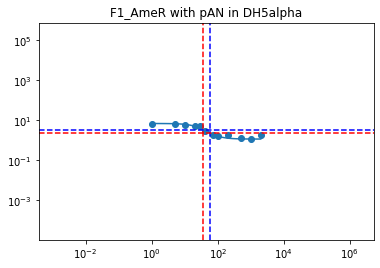

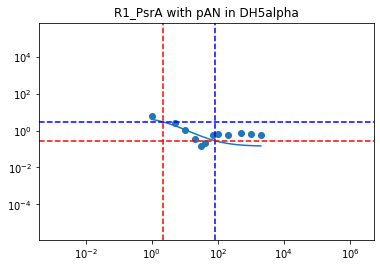

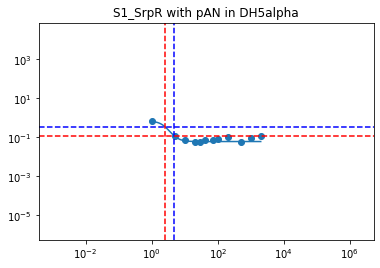

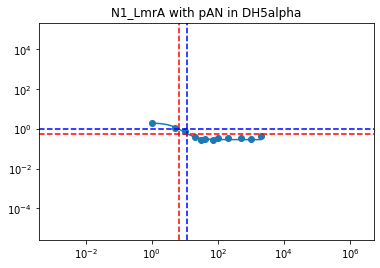

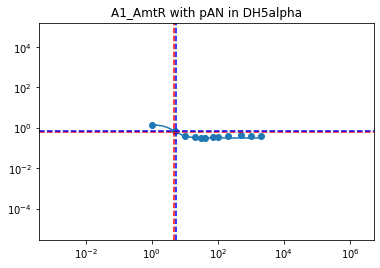

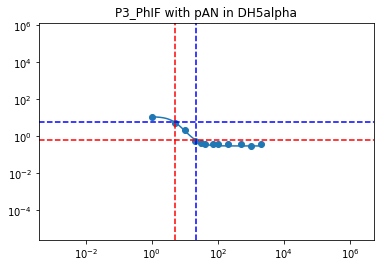

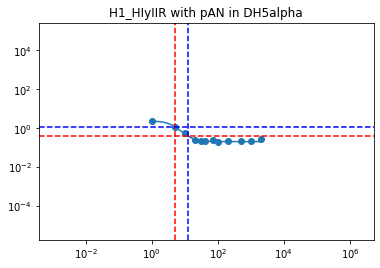

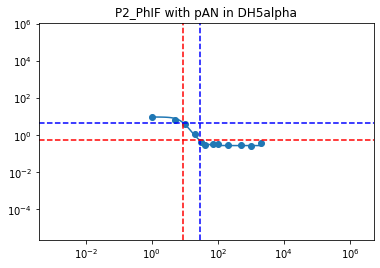

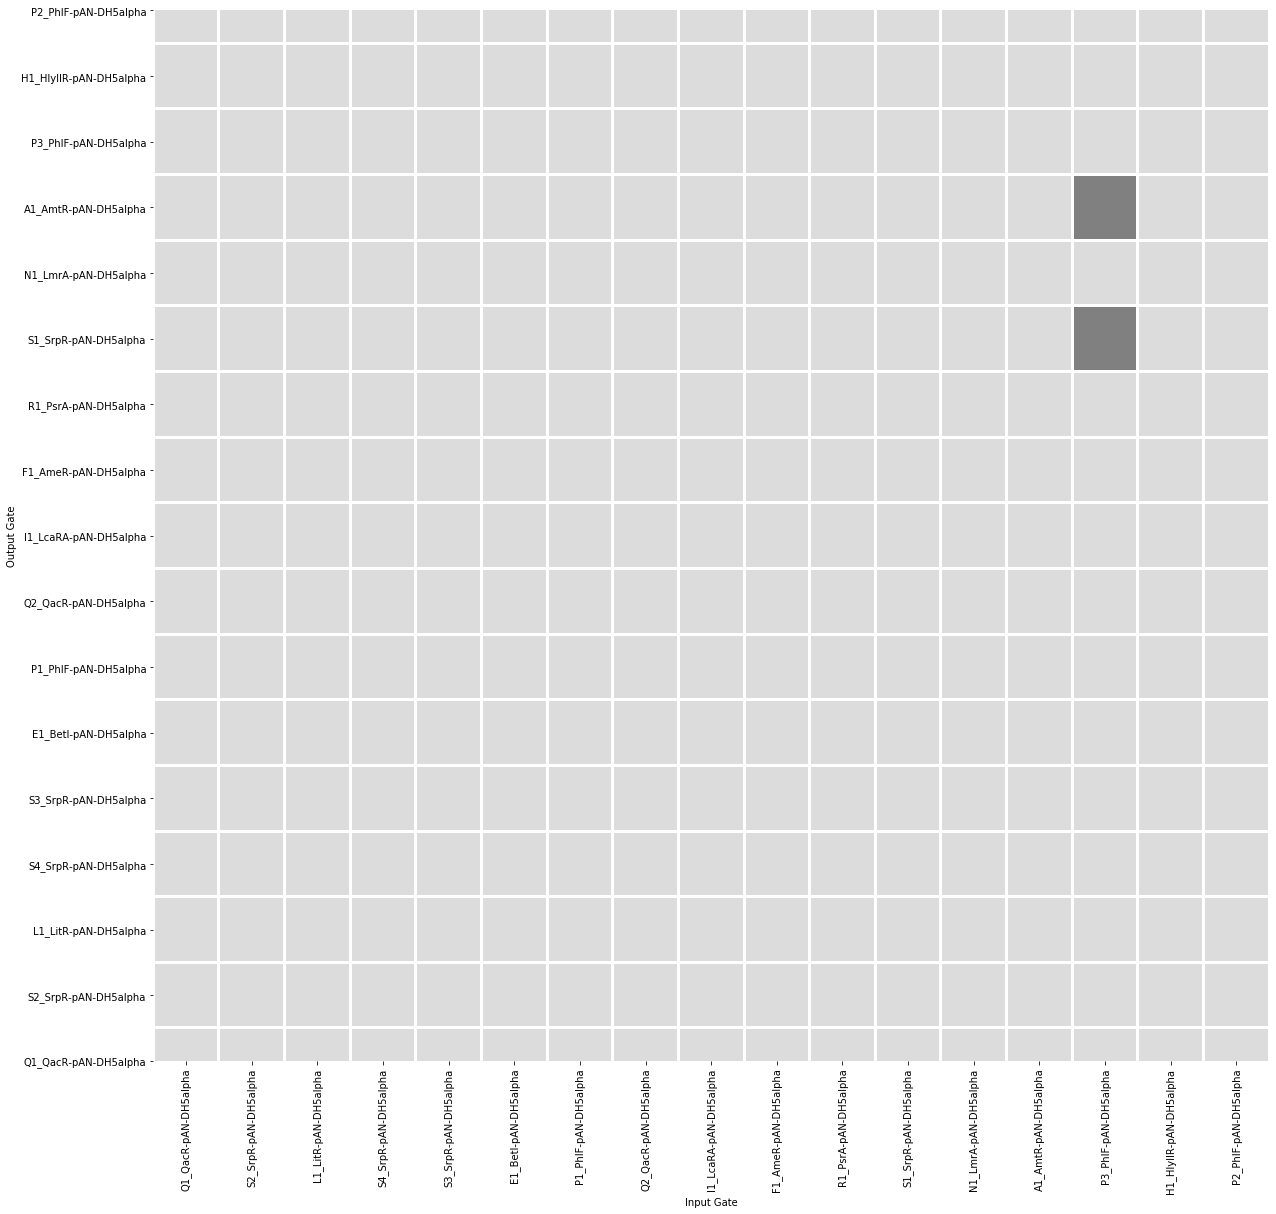

In [10]:
DH5alpha_pAN = list(filter(lambda g: g.host == 'DH5alpha' and g.backbone == 'pAN', valid_gates))
for gate in DH5alpha_pAN:
    gate.quickplot.show()
    
print(f"There are {len(DH5alpha_pAN)} valid gates.")

compat_map(DH5alpha_pAN)

In [11]:
for a in DH5alpha_pAN:
    for b in DH5alpha_pAN:
        if a.is_compatible_with(b):
            print(f"{a} is compatible with {b}")

P3_PhIF in DH5alpha with pAN is compatible with S1_SrpR in DH5alpha with pAN
P3_PhIF in DH5alpha with pAN is compatible with A1_AmtR in DH5alpha with pAN
